# NLP Assignment 1 (40% of grade): Sentiment Analysis from Tweets

This coursework will involve you implementing functions for a text classifier, which you will train to identify the **sentiment expressed in a text** in a dataset of approx. 27,000 entries, which will be split into a 80%/20% training/test split.

In this template you are given the basis for that implementation, though some of the functions are missing, which you have to fill in.

Follow the instructions file **NLP_Assignment_1_Instructions.pdf** for details of each question - the outline of what needs to be achieved for each question is as below.

You must submit all **ipython notebooks and extra resources you need to run the code if you've added them** in the code submission, and a **2 page report (pdf)** in the report submission on QMPlus where you report your methods and findings according to the instructions file for each question.

# Questions 5: Optimising pre-processing and feature extraction (30 marks)

In [214]:
!pip install nltk

In [215]:
import nltk
import string
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import regex as re
import csv    

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [216]:
from collections import Counter

def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))

    n_of_words_per_sentance_train = []
    n_of_words_per_sentance_test = []

    global_feature_dict_positive = Counter()
    global_feature_dict_negative = Counter()

    for (text, label) in raw_data[:num_training_samples]:
        tokens = pre_process(text)
        n_of_words_per_sentance_train.append(len(tokens))
        fv = to_feature_vector_weighted(tokens)
        train_data.append((fv,label))
        update_bag_of_words(label, fv, global_feature_dict_positive, global_feature_dict_negative)
        
    for (text, label) in raw_data[num_training_samples:]:
        tokens = pre_process(text)
        n_of_words_per_sentance_test.append(len(tokens))
        fv = to_feature_vector_weighted(tokens)
        test_data.append((fv,label))
        update_bag_of_words(label, fv, global_feature_dict_positive, global_feature_dict_negative)
        
    avr_words_per_sentance_train = int(sum(n_of_words_per_sentance_train)/len(n_of_words_per_sentance_train))
    avr_words_per_sentance_test = int(sum(n_of_words_per_sentance_test)/len(n_of_words_per_sentance_test))
    print(' *** The average number of features per sentence for train dataset = {}'.format(avr_words_per_sentance_train))
    print(' *** The average number of features per sentence for test dataset = {}'.format(avr_words_per_sentance_test))

    return global_feature_dict_positive, global_feature_dict_negative

def update_bag_of_words(label, feature, global_feature_dict_a, global_feature_dict_b):
    '''
    This method will update the bag of words for positive and negative label.
    Parameter:
        It takes label, features, global_feature_dict for positive label, and global_feature_dict
        for negative label.

    This method will not return any variable. It will update the global feature dict according to label.
    '''
    if label == 'positive':
        global_feature_dict_a.update(feature.keys())
    else:
        global_feature_dict_b.update(feature.keys())

# test bag of words for positive & bag of words for negative
global_feature_dict_a =Counter()
global_feature_dict_b =Counter()
update_bag_of_words('positive', {"a":1, "b":2}, global_feature_dict_a, global_feature_dict_b)
update_bag_of_words('positive', {"a":1, "c":2}, global_feature_dict_a, global_feature_dict_b)
print(global_feature_dict_a)

Counter({'a': 2, 'b': 1, 'c': 1})


# Input and Basic preprocessing

In [217]:
def parse_data_line(data_line):
    ''' 
    Function takes a data line which is an array of string element.
    Returns:
        if valid length returns tuple of (label, text)
        else tuple of (None, None)
    '''
    if len(data_line) >= 3:
        return (data_line[1], data_line[2])

In [218]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# To store number of words per sentance
number_of_words_per_sentence = []

def pre_process(text):
    '''
    After doing a sentence segmentation, we want to extract tokens from a sentence.
    This method takes a string (sentence) and returns all the tokens. Tokens are
    nothing but words.
    '''
    text = re.sub(r'http.\S+', '', text )
    
    # We are separating any punctuation symbols from the end and the beginning.
    # This will be helpful in subsequent filtering of tokens where we do/don't require punctuation as per our need.
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
    
    # Now, we can just split the sentence by whitespace.
    tokens = re.split(r"\s+",text)
    
    # Normalisation - transform all the tokens in lowercase because different cases 
    # might be inferred as a different feature that we don't want
    tokens = [t.lower() for t in tokens]

    # Let's add stop words filter. This will remove words like "the", "and", "is" etc 
    stop_words = set(stopwords.words('english'))
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words]

    # Let's filter out tokens that are punctuation. I might need to remove this if the accuracy is decreasing.
    tokens = [token for token in tokens if token not in string.punctuation]

    # Let's lemmatize tokens to their base form to normalize the data and also reduce the irrelevant features
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens


# Unit testing this function
# Test Case 1 - Positive Test Case
processed_text = pre_process("https://t.co/Nt2a0llMwL I love India, and it is very beautiful country. https://t.co/Nt2a0llMwL")
print(processed_text)
assert processed_text == ['love', 'india', 'beautiful', 'country']

# Test Case 2 - Positive Test Case (repeated words)
processed_text = pre_process("I love India, and India is very beautiful country.")
print(processed_text)
assert processed_text == ['love', 'india', 'india', 'beautiful', 'country']


['love', 'india', 'beautiful', 'country']
['love', 'india', 'india', 'beautiful', 'country']


# Basic Feature Extraction

In [219]:
from collections import Counter
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# To store a global counter of words/tokens for the document. This represents a bag of words. 
global_feature_dict = Counter()
def to_feature_vector(tokens):
    '''
    Extracts feature from a list of tokens.
    Parameter:
        A list of tokens for a sentence.
    Returns:
        A dictionary of tokens and corresponding weight. The weight will be zero/one since following a binary approach.
    '''
    
    # Using bigram to get more quality features
    bigrams = list(ngrams(tokens, 2))
    
    # Initialize a CountVectorizer with binary feature values and ngram_range
    # # Case 1
    vectorizer = CountVectorizer(binary=True, ngram_range=(1,2), max_features=200000)

    # Case 2
    # vectorizer = CountVectorizer(binary=True, ngram_range=(1,2))
    
    features = tokens + [' '.join(bigram) for bigram in bigrams]
    vector_transformation = vectorizer.fit_transform(features)

    # Get feature names ie words in the sentence
    feature_names = vectorizer.get_feature_names_out()
    
    # Update the global feature dictionary
    global_feature_dict.update(feature_names)

    '''
    Create a dictionary to return with the token as key and weight as value.

    Using two approaches for the weight of the token:-
    a) Applying weight as 1 for each word
    b) Applying weight as the occurrence of the word - bag of word representation
    Note:- The observations of the above approaches are given in the report.
    '''
    
    # feature_vector = dict(zip(feature_names, vector_transformation.sum(axis=0).A1)) # Applying weight as the occurrence of the word - bag of word representation
    feature_vector = {token: 1 for token in feature_names} # 
    return feature_vector

def to_feature_vector_weighted(tokens):

    '''
    Extracts feature from a list of tokens.
    Parameter:
        A list of tokens for a sentence.
    Returns:
        A dictionary of tokens and corresponding weight (frequency/occurrence).
    '''
    
    # Using bigram to get more quality features
    bigrams = list(ngrams(tokens, 2))
    features = tokens + [' '.join(bigram) for bigram in bigrams]
    
    featureVector = {}  # local feature vector for this example (in dict form)
    for word in features:
        try:
            featureVector[word] += 1
        except KeyError:
            # else if it's not in the local feature vector, create the entry with 1/n weight
            featureVector[word] = 1 #(1.0/len(words))

    global_feature_dict.update(featureVector.keys())
    return featureVector

# Unit testing this function
# Test Case 1 - Positive Test Case
token = pre_process("My favorite game is chess")
test_case_1_result = to_feature_vector_weighted(token)
print(test_case_1_result)
print(global_feature_dict)
assert test_case_1_result == {'chess': 1, 'favorite': 1, 'favorite game': 1, 'game': 1, 'game chess': 1}
assert global_feature_dict == {'chess': 1, 'favorite': 1, 'favorite game': 1, 'game': 1, 'game chess': 1}

# Test Case 1 - Positive Test Case
token = pre_process("NLP is my favorite subject, :)")
test_case_2_result = to_feature_vector(token)
print(test_case_2_result)
print(global_feature_dict)
assert test_case_2_result == {'favorite': 1, 'favorite subject': 1, 'nlp': 1, 'nlp favorite': 1, 'subject': 1}
assert global_feature_dict == {'favorite': 2, 'chess': 1, 'favorite game': 1, 'game': 1, 'game chess': 1, 'favorite subject': 1, 'nlp': 1, 'nlp favorite': 1, 'subject': 1}


{'favorite': 1, 'game': 1, 'chess': 1, 'favorite game': 1, 'game chess': 1}
Counter({'favorite': 1, 'game': 1, 'chess': 1, 'favorite game': 1, 'game chess': 1})
{'favorite': 1, 'favorite subject': 1, 'nlp': 1, 'nlp favorite': 1, 'subject': 1}
Counter({'favorite': 2, 'game': 1, 'chess': 1, 'favorite game': 1, 'game chess': 1, 'favorite subject': 1, 'nlp': 1, 'nlp favorite': 1, 'subject': 1})


In [220]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):

    '''
    There are cases defined for the analysis of SVM parameters.
    Uncomment to run the model accordingly.
    '''
    # # Case 1
    # print("Training Classifier...")
    # pipeline =  Pipeline([('svc', LinearSVC(dual='auto', C=1.0))])

    # # Case 2
    # class_weights = {0: 10.0, 1: 1.0}
    # pipeline =  Pipeline([('svc', LinearSVC(dual='auto', C=1.0, class_weight=class_weights, max_iter= 100000))])

    # # Case: 3
    class_weights = {0: 100.0, 1: 1.0}
    pipeline =  Pipeline([('svc', LinearSVC(dual='auto', C=1.0, class_weight=class_weights, max_iter= 100000))])
    return SklearnClassifier(pipeline).train(data)


# Cross-validation

In [221]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(pre_process(samples)))

In [222]:
#solution
from sklearn.metrics import classification_report
import numpy as np

cv_results = {}
label_for_train_data = []
prediction_label = []
def cross_validate(dataset, folds):
    '''
    Perform 10-fold cross-validation. 

    Parameter:
        Input dataset and folds for analysis

    Return:
        Aggregated cv result for precision_metric, recall_metric, f1_metric, and accuracy
    '''
    results = []
    fold_size = int(len(dataset)/folds) + 1
    
    for i in range(0,len(dataset),int(fold_size)):
        print("Fold start on items %d - %d" % (i, i+fold_size))

        # Test and train dataset preparation
        test_data_fold = dataset[i:i + fold_size]
        train_data_fold = dataset[:i] + dataset[i + fold_size:]

        count_of_positive = [label for text, label in train_data_fold if label == 'positive']
        count_of_negative = [label for text, label in train_data_fold if label == 'negative']
        
        # features (X) and labels (y) from the training dataset and training of the classifier model
        feature_for_train_data = [train_text for train_text, train_label in train_data_fold]
        label_for_train_data = [train_label for train_text, train_label in train_data_fold]
        classifier = train_classifier(list(zip(feature_for_train_data, label_for_train_data)))

        # features (X) and labels (y) from the testing dataset and predicting labels using the classifier model
        feature_for_test_data = [test_text for test_text, test_label in test_data_fold]
        label_for_test_data = [test_label for test_text, test_label in test_data_fold]
        prediction_label = [predict_labels(text, classifier) for text in feature_for_test_data]

        '''
        Once we have predicted the labels for the test data, we can measure the drift between the 
        labels given for the test data and the labels predicted for the test data.

        As given in the question we will be calculating precision, recall, f1 score, and accuracy
        '''
        precision_metric, recall_metric, f1_metric, _ = precision_recall_fscore_support(label_for_test_data, prediction_label, average='weighted')
        
        accuracy_metric = accuracy_score(
            label_for_test_data, prediction_label)

        # Store results for this fold
        results.append({
            'precision': precision_metric,
            'recall': recall_metric,
            'f1': f1_metric,
            'accuracy': accuracy_metric
        })

    cv_results = {
        'precision': np.mean([d["precision"] for d in results]),
        'recall': np.mean([d["recall"] for d in results]),
        'f1': np.mean([d["f1"] for d in results]),
        'accuracy': np.mean([d["accuracy"] for d in results])}
    return cv_results


In [223]:
# MAIN
import random
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset

# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path)

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

b_of_words_positive, b_of_words_negative = split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\t')


print()
print("********************* Starting 10 Fold Cross Validation *********************")

# Shuffle the dataset to reduce the imbalance of the dataset. 
random.seed(42)
random.shuffle(train_data)
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
 *** The average number of features per sentence for train dataset = 11
 *** The average number of features per sentence for test dataset = 11
After split, 33540 rawData, 26832 trainData, 6708 testData	Training Samples: 	26832	Features: 	320629

********************* Starting 10 Fold Cross Validation *********************
Fold start on items 0 - 2684
Fold start on items 2684 - 5368
Fold start on items 5368 - 8052
Fold start on items 8052 - 10736
Fold start on items 10736 - 13420
Fold start on items 13420 - 16104
Fold start on items 16104 - 18788
Fold start on items 18788 - 21472
Fold start on items 21472 - 24156
Fold start on items 24156 - 26840


{'precision': 0.8589115528556798,
 'recall': 0.8602039100109378,
 'f1': 0.8584929681048521,
 'accuracy': 0.8602039100109378}

In [224]:
word = 'fun'
print('The count of word: {} in positive bag is {}'.format(word, b_of_words_positive[word]))
print('The count of word: {} in negative bag is {}'.format(word, b_of_words_negative[word]))

print('The most common word: {} in positive bag is {}'.format(word, b_of_words_positive.most_common(10)))
print('The most common word: {} in negative bag is {}'.format(word, b_of_words_negative.most_common(10)))



The count of word: fun in positive bag is 273
The count of word: fun in negative bag is 19
The most common word: fun in positive bag is [('tomorrow', 3778), ('...', 2522), ('may', 2408), ('day', 2253), ('see', 1727), ('night', 1561), ('going', 1385), ('friday', 1374), ('good', 1321), ('time', 1252)]
The most common word: fun in negative bag is [('may', 1676), ('...', 1152), ('tomorrow', 998), ('like', 815), ('trump', 614), ('get', 606), ('day', 549), ('1st', 532), ('going', 511), ('u', 497)]


# Error Analysis

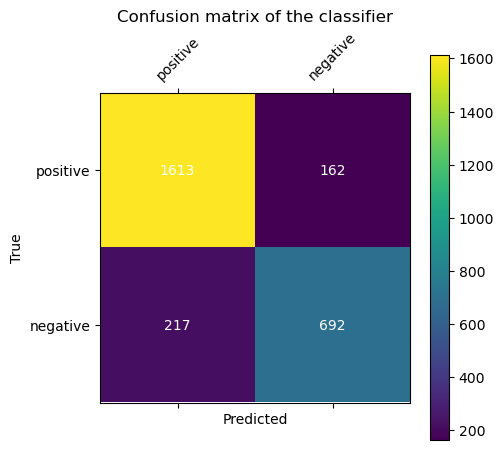

Classification Report Values:
               precision    recall  f1-score   support

    negative       0.81      0.76      0.79       909
    positive       0.88      0.91      0.89      1775

    accuracy                           0.86      2684
   macro avg       0.85      0.84      0.84      2684
weighted avg       0.86      0.86      0.86      2684

**** Writing FALSE POSITIVE and FALSE NEGATIVE detection (ref: fp_fn.csv)****


In [225]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')

    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

    return cm

def write_csv(file_name):
    '''
    Writes CSV file with FN and FP cases of classification
    
    Parameter: 
    It takes file name as parameter

    '''
    records = []        
    for text, r, expected, actual in zip(text_for_test_data, text_for_test_data_r, label_for_test_data, prediction_label):
        if expected == actual:
            continue
            
        records.append([expected, actual, text, r])
    
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        for record in records:
            writer.writerow(record)


'''
To look at the performance of the classes we will use the above function and
pass labels for the test data and predicted labels to see what the balance of 
false positives and false negatives for the positive and negative labels. 
'''

#Fetching a single fold data to carry out an error analysis
fold_size = int(len(train_data)/10) + 1
first_fold_test_data = train_data[:fold_size]
first_fold_train_data = train_data[fold_size:]

first_fold_test_data_r = raw_data[:fold_size]
first_fold_train_data_r = raw_data[fold_size:]
text_for_test_data_r = [text for text, label in first_fold_test_data_r]

# Extracting feature and label for training classifier
feature_for_train_data = [text for text, label in first_fold_train_data]
label_for_train_data = [label for text, label in first_fold_train_data]
classifier = train_classifier(list(zip(feature_for_train_data, label_for_train_data)))

# Extracting feature and label for testing model
text_for_test_data = [text for text, label in first_fold_test_data]
label_for_test_data = [label for text, label in first_fold_test_data]
prediction_label = [classifier.classify(text) for text in text_for_test_data]

# Invoking confusion_matrix_heatmap method to print confusion matrix
confusion_matrix_heatmap(label_for_test_data, prediction_label, labels=['positive', 'negative'])

# Print classification report that will have measures like recall, precision, f1 score of label.
report = classification_report(label_for_test_data, prediction_label)
print("Classification Report Values:\n", report)

# Write FP and FN cases in CSV file - FileName is fp_fn_Optimized.csv
print('**** Writing FALSE POSITIVE and FALSE NEGATIVE detection (ref: fp_fn.csv)****')
write_csv("fp_fn_Optimized.csv") 


({'tomorrow': 1, 'release': 1, '58th': 1, 'episode': 1, '#hsonair': 1, 'profiling': 1, '@alissadossantos': 1, 'talk': 1, 'storytelling': 1, 'beyonce': 1, 'tomorrow release': 1, 'release 58th': 1, '58th episode': 1, 'episode #hsonair': 1, '#hsonair profiling': 1, 'profiling @alissadossantos': 1, '@alissadossantos talk': 1, 'talk storytelling': 1, 'storytelling beyonce': 1}, 'positive')
Done training!
Precision: 0.859914
Recall: 0.861360
F Score:0.859738


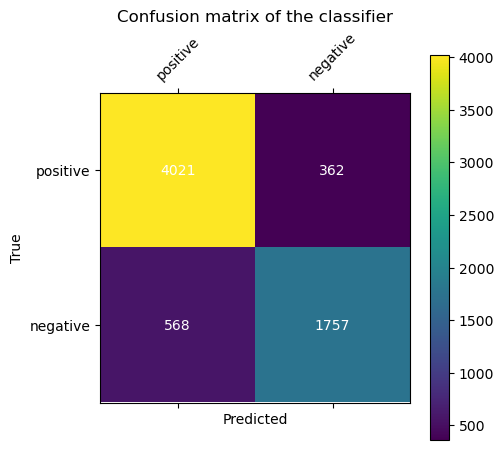

Classification Report Values:
               precision    recall  f1-score   support

    negative       0.83      0.76      0.79      2325
    positive       0.88      0.92      0.90      4383

    accuracy                           0.86      6708
   macro avg       0.85      0.84      0.84      6708
weighted avg       0.86      0.86      0.86      6708



In [226]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

    confusion_matrix_heatmap(test_true, test_pred, labels=['positive', 'negative'])
    report = classification_report(test_true, test_pred)
    print("Classification Report Values:\n", report)
